In [1]:
import os
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [2]:
def file_open(input):
    sentences1 = []
    sentences2 = []
    with open(input, 'r', encoding='utf-8') as fileobj:
        while True:
            line = fileobj.readline()
            if line :
                s = line.split('\t')
                s[0] = s[0].rstrip().replace('.', ' ').replace('"', ' ').replace("'", " ").replace("-", " ").replace(":", " ").replace("%", " ").replace("*", " ").replace("!", " ").replace("?", " ").replace("@", " ").replace('/', ' ').replace(",", ' ').replace('(', ' ').replace(')', ' ').replace('#', ' ')
                sentences1.append(s[0])
                s[1] = s[1].rstrip().replace('.', ' ').replace('"', ' ').replace("'", " ").replace("-", " ").replace(":", " ").replace("%", " ").replace("*", " ").replace("!", " ").replace("?", " ").replace("@", " ").replace('/', ' ').replace(",", ' ').replace('(', ' ').replace(')', ' ').replace('#', ' ')
                sentences2.append(s[1])
            else:
                break
    return sentences1, sentences2

In [3]:
def label_open(input):
    with open(input, "r") as fileobj:
        labels = [float(s.strip())/5. for s in fileobj.readlines()]
    labels = np.asarray(labels)
    return labels

In [4]:
import numpy as np
sentences1, sentences2 = file_open("input/STS.input.OnWN.txt")
labels = label_open("gs/STS.gs.OnWN.txt")

sentences1n, sentences2n = file_open("input/STS.input.MSRvid.txt")
sentences1 = np.concatenate([sentences1, sentences1n], axis=0)
sentences2 = np.concatenate([sentences2, sentences2n], axis=0)
labelsn = label_open("gs/STS.gs.MSRvid.txt")
labels = np.concatenate([labels, labelsn], axis=0)

sentences1n, sentences2n = file_open("input/STS.input.SMTeuroparl.txt")
sentences1 = np.concatenate([sentences1, sentences1n], axis=0)
sentences2 = np.concatenate([sentences2, sentences2n], axis=0)
labelsn = label_open("gs/STS.gs.SMTeuroparl.txt")
labels = np.concatenate([labels, labelsn], axis=0)


sentences1n, sentences2n = file_open("input/STS.input.tweet-news.txt")
sentences1 = np.concatenate([sentences1, sentences1n], axis=0)
sentences2 = np.concatenate([sentences2, sentences2n], axis=0)
labelsn = label_open("gs/STS.gs.tweet-news.txt")
labels = np.concatenate([labels, labelsn], axis=0)


In [5]:
from nltk.stem import *
from keras.preprocessing.text import *
from keras.preprocessing.sequence import pad_sequences
import nltk


def lemmatize(texts):
    s = []
    a = np.zeros((len(texts), 75, 300))
    for text in texts:
        s.append(text_to_word_sequence(text))
    for i, text in enumerate(s):
        for j, word in enumerate(text):
            if word in word2vec:
                a[i][j][:] = word2vec[word]
            else:
                continue
    return a

Using TensorFlow backend.


In [6]:
max_len = 75
data_left = lemmatize(sentences1)
data_right = lemmatize(sentences2)

labels = np.asarray(labels)
print('Shape of data tensor:', data_left.shape)
print('Shape of labels tensor:', labels.shape)

indices = np.arange(data_left.shape[0])
np.random.shuffle(indices)
data_left = data_left[indices]
data_right = data_right[indices]
labels = labels[indices]


Shape of data tensor: (2984, 75, 300)
Shape of labels tensor: (2984,)


In [5]:
import keras
from keras.layers import *
from keras.models import *
from keras_self_attention import SeqSelfAttention
max_len = 75

def build_model():
    input_left = Input(shape=(max_len, 300), name='input1')
    input_right = Input(shape=(max_len, 300), name='input2')
   

    attention = SeqSelfAttention(attention_activation='sigmoid', kernel_regularizer=keras.regularizers.l2(1e-6), bias_regularizer=keras.regularizers.l1(1e-4), attention_regularizer_weight=1e-4)

    conv1 = Conv1D(300, 3, activation='relu')
    conv2 = Conv1D(300, 5, activation='relu')
    conv3 = Conv1D(300, 7, activation='relu')
    
    embed_left = attention(input_left)

    left1 = conv1(embed_left)
    left1 = MaxPooling1D(2)(left1)
    left1 = GlobalAveragePooling1D()(left1)
      
    left2 = conv2(embed_left)
    left2 = MaxPooling1D(2)(left2)
    left2 = GlobalAveragePooling1D()(left2)
      
    left3 = conv3(embed_left)
    left3 = MaxPooling1D(2)(left3)
    left3 = GlobalAveragePooling1D()(left3)
  
    all_embed_left = GlobalAveragePooling1D()(input_left)

    left1 = add([left1, all_embed_left])
    left2 = add([left2, all_embed_left])
    left3 = add([left3, all_embed_left])


    
    embed_right = attention(input_right)

    right1 = conv1(embed_right)
    right1 = MaxPooling1D(2)(right1)
    right1 = GlobalAveragePooling1D()(right1)
    
    right2 = conv2(embed_right)
    right2 = MaxPooling1D(2)(right2)
    right2 = GlobalAveragePooling1D()(right2)
    
    right3 = conv3(embed_right)
    right3 = MaxPooling1D(2)(right3)
    right3 = GlobalAveragePooling1D()(right3)
    
    all_embed_right = GlobalAveragePooling1D()(input_right)
    

    right1 = add([right1, all_embed_right])
    right2 = add([right2, all_embed_right])
    right3 = add([right3, all_embed_right])

    out1 = Dot(axes=-1, normalize=True)([left1, right1])
    out2 = Dot(axes=-1, normalize=True)([left2, right2])
    out3 = Dot(axes=-1, normalize=True)([left3, right3])
   
    out = average([out1, out2, out3])

    model = Model(inputs=[input_left, input_right], output=out)

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    model.summary()
    return model

/Users/suekanekeiichi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("av...)`


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 75, 300)      0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 75, 300)      0                                            
__________________________________________________________________________________________________
seq_self_attention_4 (SeqSelfAt (None, 75, 300)      19265       input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 73, 300)      270300      seq_self_attention_4[0][0] 

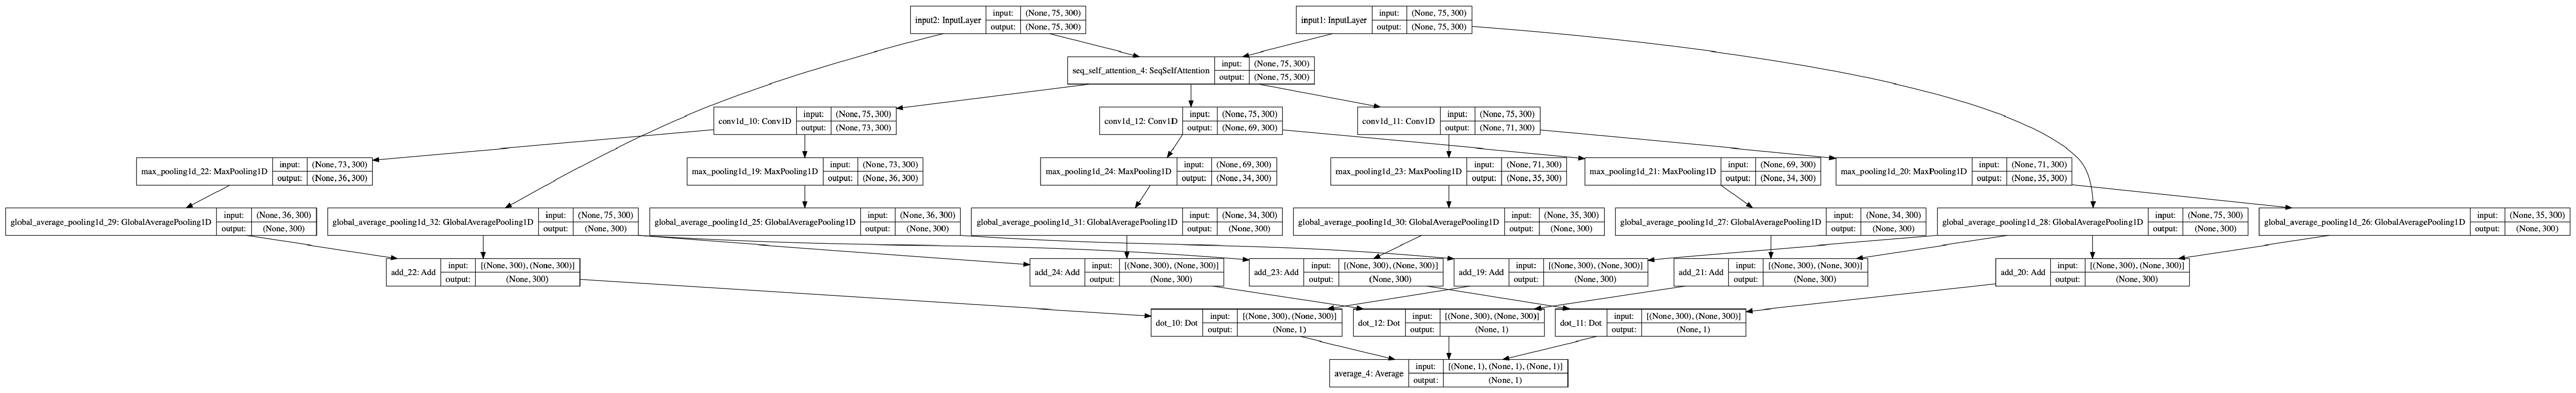

In [6]:
from keras.callbacks import *
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import *

model = build_model()
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
im = Image.open('cnn_model.png')
plt.figure(figsize=(100,100))
plt.axis('off')
plt.imshow(np.array(im))
plt.show()
#history = model.fit([data_left, data_right], labels, validation_split=0.2, epochs=20, batch_size=100, callbacks=[ModelCheckpoint(filepath='my_model_cnn.h5', monitor='val_loss', save_best_only=True)])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
num_epochs=100

mae = history.history["mae"]
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, loss, 'bo', label='Traing loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, mae, 'bo', label='Traing mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

plt.show()

In [10]:
test1, test2 = file_open("input/STS.input.images.txt")
test1 = lemmatize(test1)
test2 = lemmatize(test2)

model.load_weights('my_model_cnn.h5')
prediction = model.predict([test1, test2])